In [158]:
import numpy as np 
import pandas as pd

import os

import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14}) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Загружаем датасет

In [22]:
df_ = pd.read_csv('Data/heart.csv', sep = ',')

Датасет содержит информацию о различных показателях здоровья человека, связанного с сердечной деятельностью.

**age** - age

**sex** - sex

**cp** - chest pain type (4 values)

**trestbps** - resting blood pressure

**chol** - serum cholestoral in mg/dl

**fbs** - fasting blood sugar > 120 mg/dl

**restecg** - resting electrocardiographic results (values 0,1,2)

**thalach** - maximum heart rate achieved

**exang** - exercise induced angina

**oldpeak** - ST depression induced by exercise relative to rest

**slope** - the slope of the peak exercise ST segment

**ca** - number of major vessels (0-3) colored by flourosopy

**thal** - 3 = normal; 6 = fixed defect; 7 = reversable defect

In [23]:
df.shape

(303, 14)

In [19]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.300,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.400,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.800,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.600,2,0,2,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Всего 303 наблюдения. Для дальнейшей работы я возьму столбик с показателями давления. 

In [300]:
df['trestbps'].describe()

count   303.000
mean    131.624
std      17.538
min      94.000
25%     120.000
50%     130.000
75%     140.000
max     200.000
Name: trestbps, dtype: float64

Построю гистограмму, чтобы посмотреть распределение показателей давления по данной выборке.

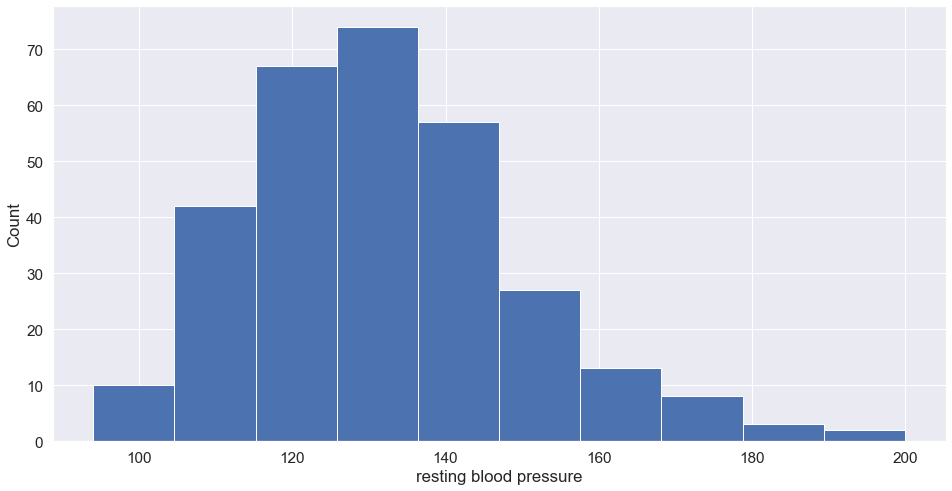

In [301]:
plt.figure(figsize = (16, 8))

df['trestbps'].hist(bins=10)
plt.ylabel('Count')
plt.xlabel('resting blood pressure')

plt.show()

Распределение близко к нормальному, медиана и среднее значение практически совпадают

1. Найдём доверительный интервал для матожидания по показателю **resting blood pressure** с точностью 95%

In [304]:
n = df['trestbps'].count()
t = 1.96
mean_ = df['trestbps'].describe()[1]
std = df['trestbps'].describe()[2]
T_1 = mean_ - std * t
T_2 = mean_ + std * t
print(f'({round(T_1, 2)} - {round(T_2, 2)})')

(97.25 - 166.0)


2. Посчитаем вероятность, что случайным образом выбранный человек имеет давление ниже 110 или выше 130, т.е. вероятность, что имеется патология. Буду считать вручную.

In [306]:
print(f'среднее значение - {mean_})')
print(f'стандартное отклонение - {std})')

среднее значение - 131.62376237623764)
стандартное отклонение - 17.53814281351709)


$Prob (-\infty < x < 110) + Prob (130 < x < \infty)=$

$=Ф\Bigl(\frac{110 - 131,62}{17,54}\Bigr) + 0,5 + 0,5 - Ф\Bigl(\frac{130 - 131,62}{17,54}\Bigr)=$

$=Ф(-1,23) + 1 - Ф(-0,09)\approx -0,39 + 1 + 0,036=0,646$

Вероятность составляет $65\%$

3. Проверим гипотезу, что артериальное давление у мужчин выше, чем у женщин. Для этого поделю данные на 2 датафрема:

    1) Показатели давления у мужчин (df_x)
    
    2) Показатели давления у женщин (df_y)

In [46]:
df['sex'].value_counts()

1    207
0     96
Name: sex, dtype: int64

In [72]:
df_x = df[df['sex']== 1][['sex', 'trestbps']]
df_y = df[df['sex']== 0][['sex', 'trestbps']]

In [71]:
df_x.head()

,sex,trestbps
0,1,145
1,1,130
3,1,120
5,1,140
7,1,120


In [73]:
df_y.head()

,sex,trestbps
2,0,130
4,0,120
6,0,140
11,0,130
14,0,150


Запишем гипотезу

$H_0: M(x) = M(y)$

$H_1: M(x) > M(y)$

Посчитаем средние показатели выборок (mean), стандартное отклонение(std) и критерий $\phi$

In [311]:
x_mean = df_x['trestbps'].describe()[1]
y_mean = df_y['trestbps'].describe()[1]
x_std = df_x['trestbps'].describe()[2]
y_std = df_y['trestbps'].describe()[2]
x_n = df_x['trestbps'].count()
y_n = df_y['trestbps'].count()
Phi = abs((x_mean - y_mean) / (x_std ** 2 / x_n + y_std ** 2 / y_n) ** (1/2))
print(f'ф = {Phi}')

ф = 0.9346487862711281


Определяем границы критической области по функции Лапласа для $\alpha=5\%$ для одностороннего интервала.

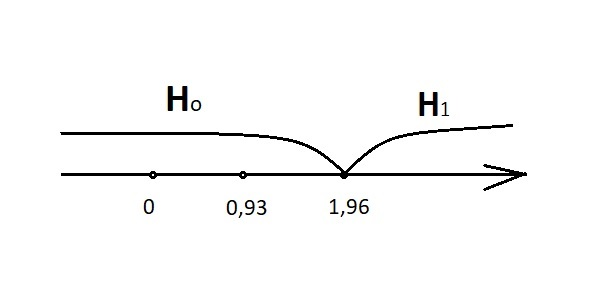

In [312]:
from IPython.display import Image
Image("Data/img.jpg")

Значение $\phi$ попадает в интервал $H_0 =>$ артериальное давление у мужчин не выше артериального давления у женщин.

4*. Посмотрим взаимосвязь возраста пациента из нашей выборки с показателями давления и максимальной частоты пульса. Для этого воспользуемся линейной регрессией и посчитаем веса данных показателей.

Создадим датафрейм только с нужными нам показателями.

In [330]:
df_reg = df[['age', 'thalach', 'trestbps']]
df_reg.head()

,age,thalach,trestbps
0,63,150,145
1,37,187,130
2,41,172,130
3,56,178,120
4,57,163,120


Посторим матрицу корреляций, чтобы посмотреть как коррелируют показатели между собой

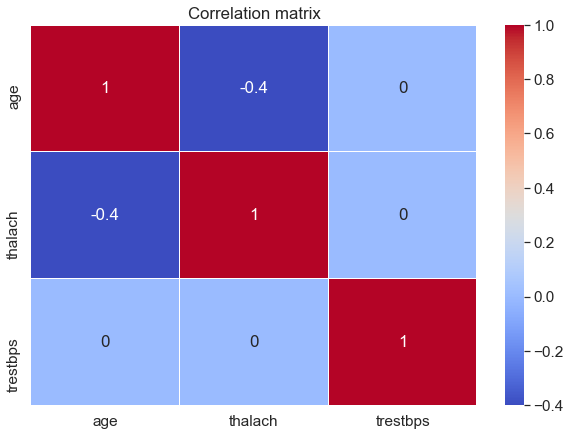

In [331]:
plt.figure(figsize = (10,7))

sns.set(font_scale=1.4)

corr_matrix = df_reg.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Видим несильную обратную корреляцию возраста с показателем максимальной частоты пульса.

Теперь в отдельный датафрейм вынесем целевой признак (y). 

In [332]:
x = df_reg[['thalach', 'trestbps']]
y = df_reg['age']

Наша регрессия будет имет такой вид:

$y_i = \beta_0 + \beta_1 \cdot x_i + \beta_2 \cdot x_i$

Воспользуемся готовой моделью линейной регрессии из библиотеки, чтобы посмотреть коэффициенты.

In [333]:
model = LinearRegression(normalize=True).fit(x, y)

In [337]:
model.__dict__

{'fit_intercept': True,
 'normalize': True,
 'copy_X': True,
 'n_jobs': None,
 'n_features_in_': 2,
 'coef_': array([-0.15317906,  0.13531934]),
 '_residues': 19256.833638040483,
 'rank_': 2,
 'singular_': array([1.02308246, 0.97637199]),
 'intercept_': 59.47786243603964}

Таким образом мы можем видеть подобранные моделью коэффициенты:

$\beta_0 = 59,47$

$\beta_1 = -0,153$

$\beta_2 = 0,135$

$y_i = 59,5 - 0,153 \cdot x_i + 0,135 \cdot x_i$

Оценим результат линейной регрессии по коэффициенту $R^2$

In [338]:
R_2 = model.score(x, y)
print(f'R^2 = {R_2}')

R^2 = 0.2269540985641616


$R^2$ совсем маленький. Попробуем определить, имеет ли данная модель значимость при 5% уровне значимости. Для этого сформулируем гипотезу:

$H_0: R^2 = 0$

$H_1: R^2 > 0$

Для доказательства гипотезы воспользуемся критерием Фишера.

In [336]:
F = (R_2 / 2) / ((1 - R_2) / (303 - 2 - 1))
F

44.037636990757356

Согласно таблице F-критерия Фишера на уровне значимости а = 0,05, при 2 оцениваемых параметрах и количестве наблюдений равному 300, F - критерий будет равен 3,03. Расчитанный нами показатель значительно больше. Значит наша модель действительно занчима и доля влияния этих показателей составляет $23\%$ 